In [1]:
import pandas as pd
from trueskill import Rating, quality_1vs1, rate_1vs1, quality, rate, global_env, choose_backend,  backends, setup
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from IPython.display import display
from ipywidgets import widgets
display(HTML("<style>.container { width:90% !important; }</style>"))

sort_order = ['date', 'compID', 'position', 'result']

In [36]:
#UTILITIES
def strip_all_strings_in_df(df_, cols_):
    for s in cols_:
        df_[s] = df_[s].apply(lambda x: x.strip())
    return df_

#LOAD DATA
def get_competition_info(df_, div_='DI'):  
    df_ = get_teams_by_division(df_, div_)                                                      
    ### REMOVE SCORE FROM STRIP
    #df_ = strip_all_strings_in_df(df_, ['first_name', 'last_name', 'college', 'location', 'division', 'score'])
    df_ = strip_all_strings_in_df(df_, ['first_name', 'last_name', 'college', 'location', 'division'])
    df_['date'] = pd.to_datetime(df_['date'], errors = 'coerce')
    df_ = df_.groupby('compID') \
        .filter(lambda x: len(x) == 20) \
        .sort_values(['date', 'compID', 'position', 'result'], ascending=True) \
        .reset_index() \
        .iloc[:,1:]
    return df_

#GET TEAM INFO
def get_teams_by_division(df_, div_='DI'):
    df_ = df_[df_["division"] == div_].drop_duplicates() \
        .reset_index().iloc[:,1:] \
        .sort_values(sort_order, ascending=True)
    return df_

#SETTING RATINGS
def set_default_player_rating(df_, div_='DI',  dict_start_rating_ = None): 
    df_players_ = df_.loc[:, ['division',  'college', 'first_name', 'last_name', 'mu', 'sigma']].copy() \
                    .drop_duplicates()
    df_players_ = strip_all_strings_in_df(df_players_, ['division',  'college', 'first_name', 'last_name'])
    df_players_ = df_players_[df_players_.division == div_]
    df_players_.loc[:,'mu'] = Rating().mu
    df_players_['sigma'] = Rating().sigma
    
    #
    if dict_start_rating_ != None:
        df_players_['name'] = df_players_['first_name'] + " " + df_players_['last_name']
        df_players_['rating'] = df_players_['name'].replace(dict_start_ratings)
        df_players_['mu'] = df_players_['rating'].where(df_players_['rating'] < 30).fillna(25)
    #
    
    df_players_ = df_players_.sort_values(['last_name', 'first_name', 'college'], ascending=True) \
        .drop_duplicates() \
        .reset_index() \
        .loc[:, ['division',  'college', 'first_name', 'last_name',  'mu', 'sigma']]

    return df_players_

def create_start_rating(_adder_dict, _df_top_players):
    df_adder= pd.DataFrame.from_dict(_adder_dict, orient='index', columns=['adder']).reset_index()
    df_adder.columns = ['name', 'adder']
    df_starting_rating = pd.merge(_df_top_players, df_adder, how='outer')
    df_starting_rating['adder'] = df_starting_rating['adder'].fillna(0)
    df_starting_rating['start_rating'] = df_starting_rating['adder']+25
    df_starting_rating.columns = ['rank', 'name', 'college', 'division', 'last_season_end_rating',
       'primary position', 'date', 'adder', 'new_season_start_rating']
    return df_starting_rating[['name', 'last_season_end_rating','new_season_start_rating']]


#GETTING RATINGS
def get_player_ratings_from_match(df_, fname_, lname_, college_):
    player_idx = df_[(df_.first_name == fname_) \
                 & (df_.last_name == lname_) \
                 & (df_.college == college_)].index
    my_mu = df_.iloc[player_idx.item(),  df_.columns.get_loc('mu')]
    my_sigma = df_.iloc[player_idx.item(),  df_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating


def set_player_ratings_after_match(df_, fname_, lname_, college_, position_,k_factor_, rating_):
    player_idx = df_[(df_.first_name == fname_) \
                 & (df_.last_name == lname_) \
                 & (df_.college == college_)].index
    df_.iloc[player_idx,  df_.columns.get_loc('mu')] = rating_.mu + k_factor_[int(position_)-1]
    #df_.iloc[player_idx,  df_.columns.get_loc('mu')] = rating_.mu
    df_.iloc[player_idx,  df_.columns.get_loc('sigma')] = rating_.sigma
    
    my_mu = df_.iloc[player_idx.item(),  df_.columns.get_loc('mu')]
    my_sigma = df_.iloc[player_idx.item(),  df_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating



# TRACK RATINGS
def create_ratings_from_matches(df_, k_factor_=[0,0,0,0,0], div_='DI', dict_start_rating_ = None):
    sort_order = ['date', 'compID', 'position', 'result']
    df_matches = get_competition_info(df_, div_)
    df_players = set_default_player_rating(df_, div_, dict_start_rating_)
    
    groups = df_matches.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        r = {}
        r_new = {}
        
        for i in range(len(value)):
            fname = df_matches.iloc[value[i], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[i], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[i], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[i], df_matches.columns.get_loc('position')]
            r[i] = get_player_ratings_from_match(df_players, fname, lname, college)

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        ((r_new[0], r_new[1]), (r_new[2], r_new[3])) = rate([t1,t2], ranks=[1,0])

        for j in range(4):
            fname = df_matches.iloc[value[j], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[j], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[j], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[j], df_matches.columns.get_loc('position')]
            set_player_ratings_after_match(df_players, \
                                           fname, \
                                           lname, \
                                           college, \
                                           position, \
                                           k_factor_, \
                                           Rating(mu=(r_new[j].mu +k_factor_[i]), sigma=r_new[j].sigma  )) 

        hist_dict[counter] = df_matches.iloc[value].merge(df_players, \
                                                          left_on=['first_name', 'last_name', 'college'], 
                                                          right_on=['first_name', 'last_name', 'college'], 
                                                          how='inner')
        counter += 1

    df_match_history = pd.concat(hist_dict.values(), axis=0) \
                        .sort_values(['date','compID'], ascending=True) \
                        .reset_index() \
                        .iloc[:,1:] \
                        .rename(columns={'division_y': 'division'})
    df_match_history['name'] = df_match_history['first_name'] + " " + df_match_history['last_name']
    
    
    df_match_history = set_primary_position( df_match_history)
    
    d = {'matches': df_matches, 'match_history': df_match_history, 'players':  df_players}
    return d


#Get player info
def set_primary_position(df_):
    df_['count_max'] = df_.groupby(['college', 'name', 'position'])['position'].transform('count')
    df_['count at primary position'] = df_.groupby(['college','name'])['count_max'].transform('max')
    idx = df_[df_['count at primary position'] == df_['count_max']]

    #primary_position = strip_all_strings_in_df(primary_position, ['college','name'])
    primary_position = idx.loc[:, ['college','name', 'position']]
    primary_position['position'] = primary_position.groupby(['name'])['position'].transform('min')
    primary_position = primary_position.drop_duplicates()

    temp = df_.merge(primary_position, on=['college', 'name'])
    temp.rename(columns = {'position_y': 'primary position', 'position_x': 'position'}, inplace=True)
    temp = temp.loc[:,['date','compID', 'location', 'first_name', 'last_name', 'name', \
          'position', 'primary position', 'college','division' ,'result', 'mu', 'sigma' ]]
    return temp

def get_top_players(df_, position_='all'):
    if position_ == 'all':
        df_top_players_ = df_.sort_values(['date', 'compID'], ascending=True).copy()
    else:
        df_top_players_ = df_[df_['primary position'] == position_].sort_values(['date', 'compID'], ascending=True).copy()
    df_top_players_ = df_top_players_.groupby(['first_name', 'last_name', 'college', 'division']) \
                                    .last() \
                                    .sort_values('mu', ascending=False) \
                                    .reset_index()
        
    df_top_players_['rank'] = df_top_players_.index+1
    df_top_players_ = df_top_players_.loc[:,['rank','name', 'college', 'division', 'mu', 'primary position', 'date']]
    df_top_players_.columns= ['rank','name', 'college', 'division', 'rating', 'primary position' ,'date']
    return df_top_players_

def get_player_rating(df, a):
    temp_df = df[df['name'] == a]
    r = Rating(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0], temp_df.groupby(['sigma'])['date'].last().sort_values(ascending=False).index[0])
    return r

def get_player_rating_history(df, a):
    temp_df = df[df['name'] == a]
    #print temp_df
    print a.upper()
    print "College: " + temp_df['college'].unique()[-1]
    print "Division: " + temp_df['division'].unique()[-1]
    print "Primary Position: " + str(temp_df['primary position'].unique()[-1])
    print "Last Rating:" + str(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0])
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(x="date", y="mu", data=temp_df)
    
    temp_df['opponent_result'] = abs(temp_df.result - 1)
    
    df_partner = pd.merge(df[df['name'] != a],temp_df, left_on=['compID', 'position', 'result'], right_on=['compID', 'position', 'result'] ) \
                    .groupby(['compID']) \
                    .first()
    df_partner.reset_index().set_index('compID')
    df_partner['Partner'] = df_partner['name_x']+' '+df_partner['mu_x'].apply(lambda x: '('+str(x)+ ')')
    df_partner = df_partner[['Partner']]
    
    df_summary = pd.merge(temp_df,df_partner, on='compID')
    
    df_opp = pd.merge(df[['name', 'mu' ,'compID', 'position', 'result']], \
                       temp_df[['compID', 'position', 'opponent_result']], 
                       left_on=['compID', 'position', 'result'], 
                       right_on=['compID', 'position', 'opponent_result']) \
                .groupby(['compID'])
    
    df_opp1 = df_opp.first().reset_index()[['compID','name', 'mu']]
    df_opp1['Opponent 1'] = df_opp1['name']+' '+df_opp1['mu'].apply(lambda x: '('+str(x)+ ')')
    df_opp2 = df_opp.last().reset_index()[['compID','name', 'mu']]
    df_opp2['Opponent 2'] = df_opp2['name']+' '+df_opp2['mu'].apply(lambda x: '('+str(x)+ ')')
    
    opp = pd.concat([df_opp1, df_opp2], axis=1)
    opp.columns = ['compID', 'name', 'mu', 'Opponent 1', 'compID1', 'name', 'mu','Opponent 2']
    opp = opp[['compID', 'Opponent 1', 'Opponent 2']]
    
    df_summary = pd.merge(df_summary,opp, on='compID')
    df_summary = df_summary[['date', 'compID', 'location', 'first_name', 'last_name', 'name', \
       'position', 'primary position', 'college', 'division', 'result', \
       'mu', 'sigma', 'Partner', 'Opponent 1', 'Opponent 2']] 
    
    return df_summary

def plot_team_players_history(df, college):
    df_team_history = df[df.college == college].sort_values('date', ascending=True)
    playercount = len(df_team_history.name.unique())
    palette = sns.color_palette("husl", playercount)
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(data=df_team_history, x="date", y="mu", hue="name", \
                 style="primary position", markers=True, palette=palette,ci=None)
    
    
def get_prior_year_player_rating_adders(df_top_players_):
    #2 standard deviations from the mean - best performers
    two_sigma = 2*df_top_players_.rating.std() + df_top_players_.rating.mean()
    high_perfomers = df_top_players_[df_top_players_['rating'] > two_sigma][['name']]
    high_perfomers['adder'] = 2

    #3 standard deviations from the mean - over-performing outliers
    three_sigma = 3*df_top_players_.rating.std() + df_top_players_.rating.mean()
    ultra_high_perfomers = df_top_players_[df_top_players_['rating'] > three_sigma][['name']]
    ultra_high_perfomers['adder'] = 1

    adder = pd.concat([high_perfomers, ultra_high_perfomers])
    adder = adder.groupby(['name'])['adder'].sum().to_frame().sort_values(['adder'], ascending=False)
    adder_dict = adder.to_dict().values()[0]
    return adder_dict


# Plotting
def plot_rating_distribution(df_, save_path_=None):
    d = df_ \
        .sort_values('date', ascending=True) \
        .groupby(['first_name', 'last_name', 'college']) \
        .last() \
        .sort_values('mu', ascending=False) \
        .reset_index()

    current_palette = sns.color_palette()

    f =  plt.figure(figsize=(30, 15))
    grid = plt.GridSpec(3, 5, wspace=.4, hspace=0.3)
    summary_ax = f.add_subplot(grid[:2, 0:])
    pos_ax = [f.add_subplot(grid[2, 4+(i*-1)], xticklabels=[], sharey=summary_ax) for i in range(5)]
    [sns.distplot( d[d['primary position'] == i+1]['mu'], ax=summary_ax,  color=current_palette[i], axlabel='Rating', hist_kws=dict(alpha=.1)) for i in range(5)]
    [sns.distplot( d[d['primary position'] == i+1]['mu'], ax=pos_ax[i], color=current_palette[i], axlabel='Position '+str(i+1))  for i in range(5)]

    if save_path_ != None:
        f.savefig(save_path_)
        
    return d

def plot_top_player_rating_distribution(df_, save_path_=None):
    f =  plt.figure(figsize=(20, 7))
    sns.distplot( df_['rating'], hist_kws=dict(alpha=.1))
    #sns.lineplot( df_['rating'])
    print df_['rating'].mean(), df_['rating'].std()
    pyplot.axvline(x=df_['rating'].mean())
    pyplot.axvline(x=df_['rating'].mean()+ df_['rating'].std(), linestyle='-.')
    pyplot.axvline(x=df_['rating'].mean()- df_['rating'].std(), linestyle='-.')
    pyplot.axvline(x=df_['rating'].mean()+ 2*df_['rating'].std(), linestyle='--')
    pyplot.axvline(x=df_['rating'].mean()- 2*df_['rating'].std(), linestyle='--')
    pyplot.axvline(x=df_['rating'].mean()+ 3*df_['rating'].std(), linestyle=':')

    if save_path_ != None:
        f.savefig(save_path_)
    return None

## Get Starting Ratings from 2017

In [9]:
df_2017 = pd.read_csv('Data/Competition-2017.csv').drop_duplicates()
df_2017.columns = ['division', 'compID', 'location', 'date', 'college', 'first_name', 'last_name', 'position', 'result', 'score']
spread_factor_minimized = [1.1, .9, .5, .3, .05]
d_2017 = create_ratings_from_matches(df_2017, spread_factor_minimized)

plot_rating_distribution(d_2017['match_history'],'2017_110_090_050_030_005/rating_distribution.pdf')

df_top_players_2017 = get_top_players(d_2017['match_history'], position_='all')
df_top_players_2017.head(100).to_csv('2017_110_090_050_030_005/top_players.csv')

dict_adder_2017 = get_prior_year_player_rating_adders(df_top_players_2017)
df_start_rating_2018 = create_start_rating(dict_adder_2017, df_top_players_2017)
df_start_rating_2018.to_csv('2017_110_090_050_030_005/top_players_next_year_starting_rating.csv')


dict_start_ratings = df_start_rating_2018[['name','new_season_start_rating' ]].set_index('name').to_dict(orient='dict')['new_season_start_rating']
dict_start_ratings

{'AJ Baumann': 25.0,
 'Abbie Harry': 25.0,
 'Abigail Moss': 25.0,
 'Abril Bustamante': 25.0,
 'Adlee Van Winden': 27.0,
 'Adore Anae': 25.0,
 'Adrianna Culbert': 27.0,
 'Aeriel Horton': 25.0,
 'Aeryn Owens': 25.0,
 'Aleksandra Djuric': 25.0,
 'Alex Holt': 25.0,
 "Alex O'Sullivan": 25.0,
 'Alexa Richardson': 25.0,
 'Alexandria Thornton': 25.0,
 'Alexis Salmons': 25.0,
 'Alexsa Parker': 25.0,
 'Ali Denney': 25.0,
 'Ali Eager': 25.0,
 'Alli Evans': 25.0,
 'Allie Elson': 25.0,
 "Allie O'Reilly": 25.0,
 'Allie Wheeler': 27.0,
 'Allison Beckman': 25.0,
 'Allison Kantor': 25.0,
 'Allison Meehan': 25.0,
 'Ally Barber': 25.0,
 'Allyson Zuhlke': 25.0,
 'Alyssa Cecil': 25.0,
 'Alyssa Kirkman': 25.0,
 'Amanda Carroll': 25.0,
 'Amber Gibson': 25.0,
 'Amie Held': 25.0,
 'Amy Neal': 25.0,
 'Amy Ozee': 25.0,
 'Amy South': 25.0,
 'Ana Ribeiro': 25.0,
 'Anabela Sataric': 25.0,
 'Andie Malloy': 25.0,
 'Andie Shelton': 25.0,
 'Anete Brinke': 25.0,
 'Anika Wilson': 25.0,
 'Anna Chin': 25.0,
 'Anna Crabtree

40.820934867380316 14.566425383082334


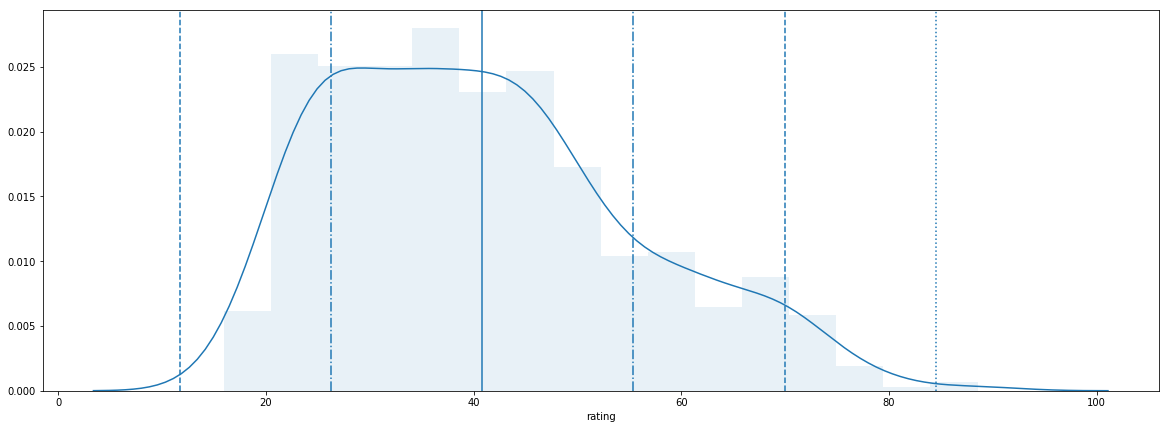

In [27]:
plot_top_player_rating_distribution(df_top_players_2017, '2017_110_090_050_030_005/top_players_rating_distribution.pdf')


## Process 2018

,rank,name,college,division,rating,primary position,date
0,1,Abril Bustamante,USC,DI,92.430350,1,2018-05-05
1,2,Nicole McNamara,UCLA,DI,86.113556,1,2018-05-06
2,3,Megan McNamara,UCLA,DI,86.113556,1,2018-05-06
3,4,Tina Graudina,USC,DI,85.528335,1,2018-05-05
4,5,Victoria Paranagua,Florida State,DI,84.869939,1,2018-05-05
5,6,Ka'iwi Schucht,Hawaii,DI,84.237515,1,2018-05-06
6,7,Emily Maglio,Hawaii,DI,84.237515,1,2018-05-06
7,8,Kristen Nuss,LSU,DI,81.191304,1,2018-05-04
8,9,Claire Coppola,LSU,DI,81.191304,1,2018-05-04
9,10,Sasha Karelov,Long Beach State,DI,79.928989,1,2018-04-28


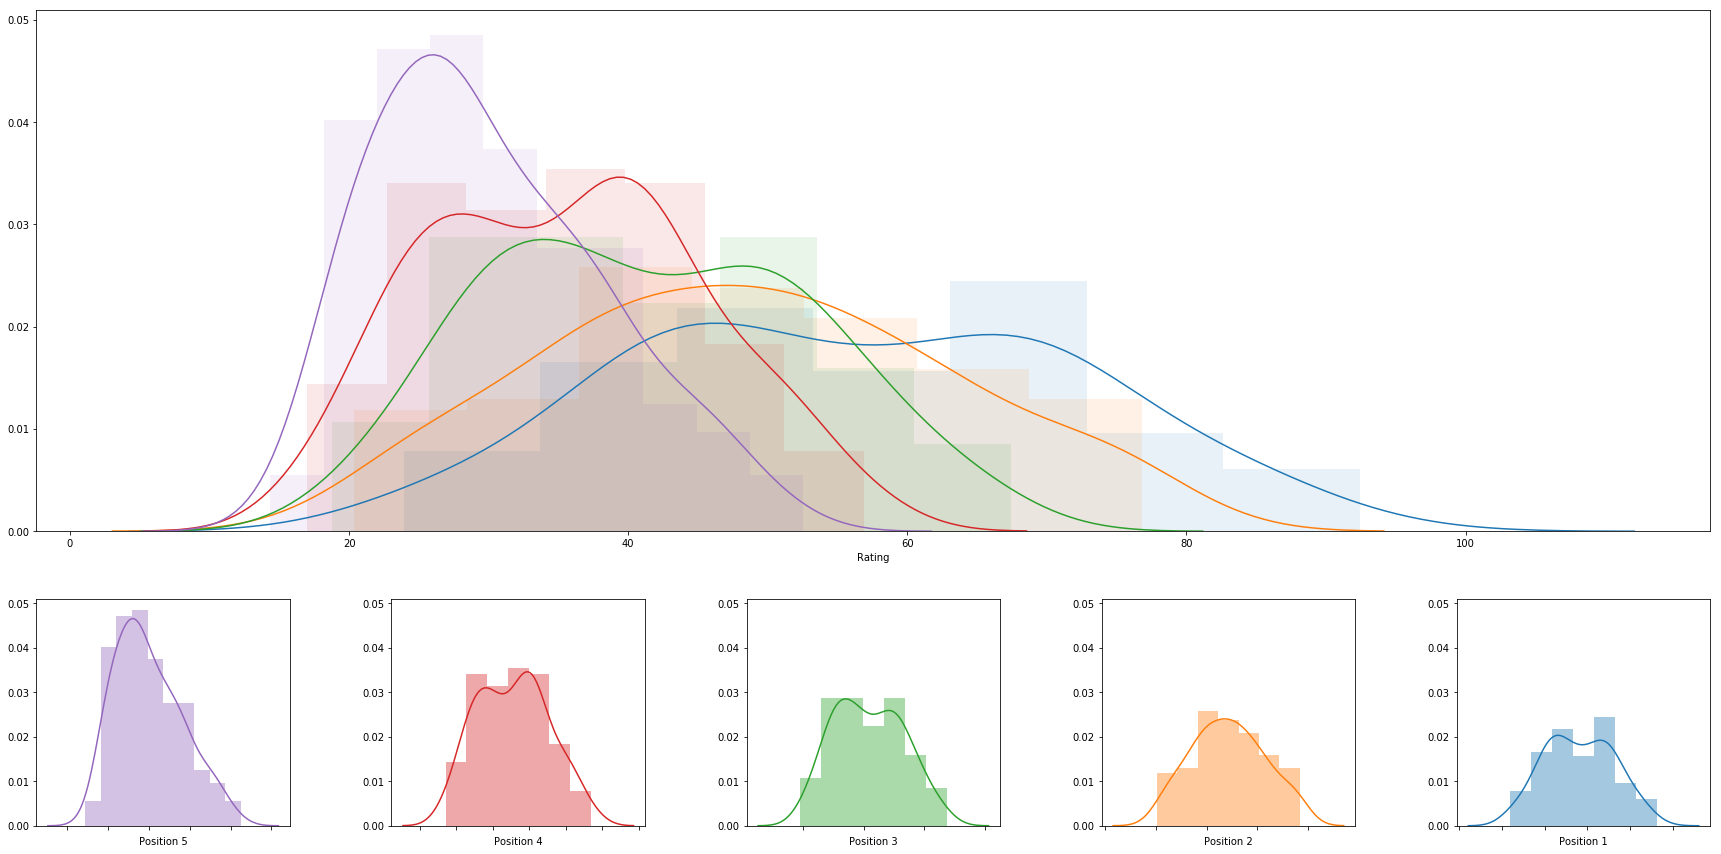

In [22]:
df_2018 = pd.read_csv('Data/Competition.csv').drop_duplicates()
df_2018.columns = ['division', 'compID', 'location', 'date', 'college', 'first_name', 'last_name', 'position', 'result', 'score']
d_2018 = create_ratings_from_matches(df_2018, spread_factor_minimized, 'DI', dict_start_ratings)

!mkdir 2018_110_090_050_030_005
plot_rating_distribution(d_2018['match_history'],'2018_110_090_050_030_005/rating_distribution.pdf')

df_top_players_2018 = get_top_players(d_2018['match_history'], position_='all')
df_top_players_2018.head(100).to_csv('2018_110_090_050_030_005/top_players.csv')
df_top_players_2018

41.21114996762256 15.192079420063186


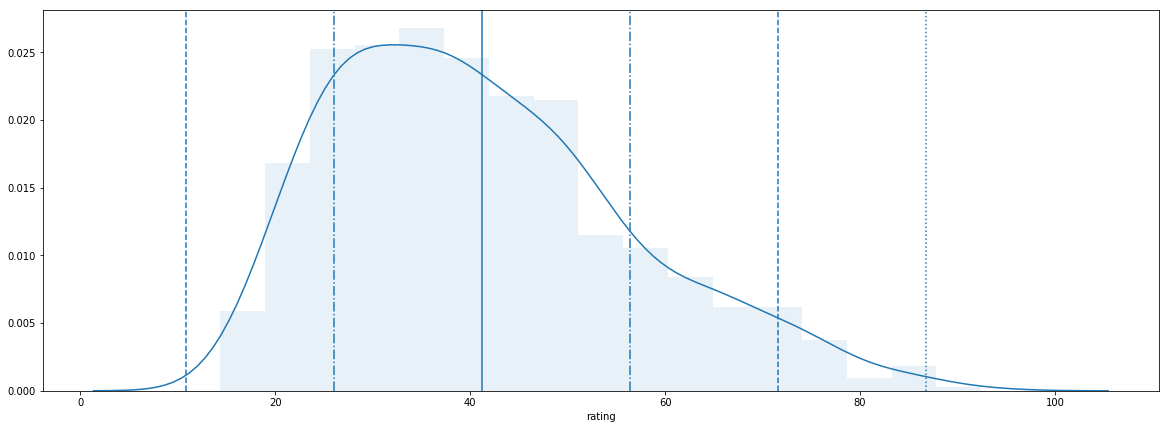

In [28]:
plot_top_player_rating_distribution(df_top_players_2018, '2018_110_090_050_030_005/top_players_rating_distribution.pdf')

In [29]:
dict_adder_2018 = get_prior_year_player_rating_adders(df_top_players_2018)
df_start_rating_2019 = create_start_rating(dict_adder_2018, df_top_players_2018)
df_start_rating_2019.to_csv('2018_110_090_050_030_005/top_players_next_year_starting_rating.csv')

dict_start_ratings = df_start_rating_2019[['name','new_season_start_rating' ]].set_index('name').to_dict(orient='dict')['new_season_start_rating']
dict_start_ratings

{'Abbey Wilson': 25.0,
 'Abby Waldburger': 25.0,
 'Abigail Devido': 25.0,
 'Abril Bustamante': 28.0,
 'Addison Hermstad': 25.0,
 'Adlee Van Winden': 25.0,
 'Adore Anae': 25.0,
 'Aeriel Horton': 27.0,
 'Aeryn Owens': 25.0,
 'Alaina Chacon': 25.0,
 'Alanya Ryan': 25.0,
 'Aleksandra Djordjevic': 25.0,
 'Aleksandra Djuric': 25.0,
 'Alex Holt': 25.0,
 'Alex Kells': 25.0,
 'Alexa Richardson': 25.0,
 'Alexa Van Komen': 25.0,
 'Alexandra Poletto': 25.0,
 'Alexia Inman': 25.0,
 'Alexis Filippone': 25.0,
 'Alexis Patterson': 25.0,
 'Ali Denney': 25.0,
 'Ali Eager': 25.0,
 'Allie Elson': 25.0,
 'Allie Havers': 25.0,
 'Allie Kemp': 25.0,
 'Allison Beckman': 25.0,
 'Allison Kantor': 25.0,
 'Ally Barber': 25.0,
 'Ally Carr': 25.0,
 'Allyssah Fitterer': 25.0,
 'Aly Brinkley': 25.0,
 'Alyssa Cecil': 25.0,
 'Amanda Carroll': 25.0,
 'Amanda Silva': 25.0,
 'Amber Gibson': 25.0,
 'Amelia Smith': 25.0,
 'Amie Held': 25.0,
 'Amy Ozee': 25.0,
 'Amy Weiss': 25.0,
 'Anabela Sataric': 25.0,
 'Andie Shelton': 25

In [32]:
df_start_rating_2019[df_start_rating_2019['new_season_start_rating'] > 25]

,name,last_season_end_rating,new_season_start_rating
0,Abril Bustamante,92.430350,28.0
1,Nicole McNamara,86.113556,27.0
2,Megan McNamara,86.113556,27.0
3,Tina Graudina,85.528335,27.0
4,Victoria Paranagua,84.869939,27.0
5,Ka'iwi Schucht,84.237515,27.0
6,Emily Maglio,84.237515,27.0
7,Kristen Nuss,81.191304,27.0
8,Claire Coppola,81.191304,27.0
9,Sasha Karelov,79.928989,27.0


ABRIL BUSTAMANTE
College: USC
Division: DI
Primary Position: 1
Last Rating:92.4303500391538


/usr/local/anaconda3/envs/Conda3/lib/python2.7/site-packages/ipykernel_launcher.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma,Partner,Opponent 1,Opponent 2
0,2018-02-24,840,"Phoenix, AZ",Abril,Bustamante,Abril Bustamante,1,1,USC,DI,1,30.620785,7.616448,Terese Cannon (30.620784845),Katie Pyles (26.3609378138),Molly Turner (26.3609378138)
1,2018-02-24,843,"Tempe, Az",Abril,Bustamante,Abril Bustamante,1,1,USC,DI,1,33.553573,7.271385,Terese Cannon (33.5535727135),Kwyn Johnson (24.5651270844),Mia Rivera (24.5651270844)
2,2018-02-25,857,"Tempe, Az",Abril,Bustamante,Abril Bustamante,1,1,USC,DI,1,35.767693,7.035092,Terese Cannon (35.7676934815),Lauren Stivrins (25.0540707589),Kelly Hunter (23.8624579675)
3,2018-02-25,861,"Tempe, Az",Abril,Bustamante,Abril Bustamante,1,1,USC,DI,1,38.430876,6.715186,Terese Cannon (38.4308756514),Tia Miric (29.8983582803),Torrey Van Winden (29.8983582803)
4,2018-02-28,878,"Los Angeles, CA",Abril,Bustamante,Abril Bustamante,1,1,USC,DI,0,37.067677,6.244287,Terese Cannon (37.0676767993),Nicole McNamara (40.9700647222),Megan McNamara (40.9700647222)
5,2018-02-28,879,"Los Angeles, CA",Abril,Bustamante,Abril Bustamante,1,1,USC,DI,0,34.300244,5.778844,Terese Cannon (34.3002440166),Madalyn Roh (35.8995425617),Brook Bauer (33.8995425617)
6,2018-03-03,924,"Malibu, CA",Abril,Bustamante,Abril Bustamante,1,1,USC,DI,1,38.601618,5.454102,Tina Graudina (32.4327093009),Madalyn Roh (34.5800571668),Brook Bauer (32.5800571668)
7,2018-03-03,925,"Malibu, CA",Abril,Bustamante,Abril Bustamante,1,1,USC,DI,1,43.087307,5.103265,Terese Cannon (36.979823329),Nicole McNamara (39.3286608377),Megan McNamara (39.3286608377)
8,2018-03-03,930,"Malibu, CA",Abril,Bustamante,Abril Bustamante,1,1,USC,DI,1,46.111489,4.876739,Tina Graudina (37.1781552787),Madalyn Roh (38.972242562),Brook Bauer (36.972242562)
9,2018-03-10,1041,"Manhattan Beach, Ca",Abril,Bustamante,Abril Bustamante,1,1,USC,DI,1,48.897472,4.703316,Tina Graudina (41.1441440887),Federica Frasca (40.8484069203),Margherita Bianchin (40.8484069203)


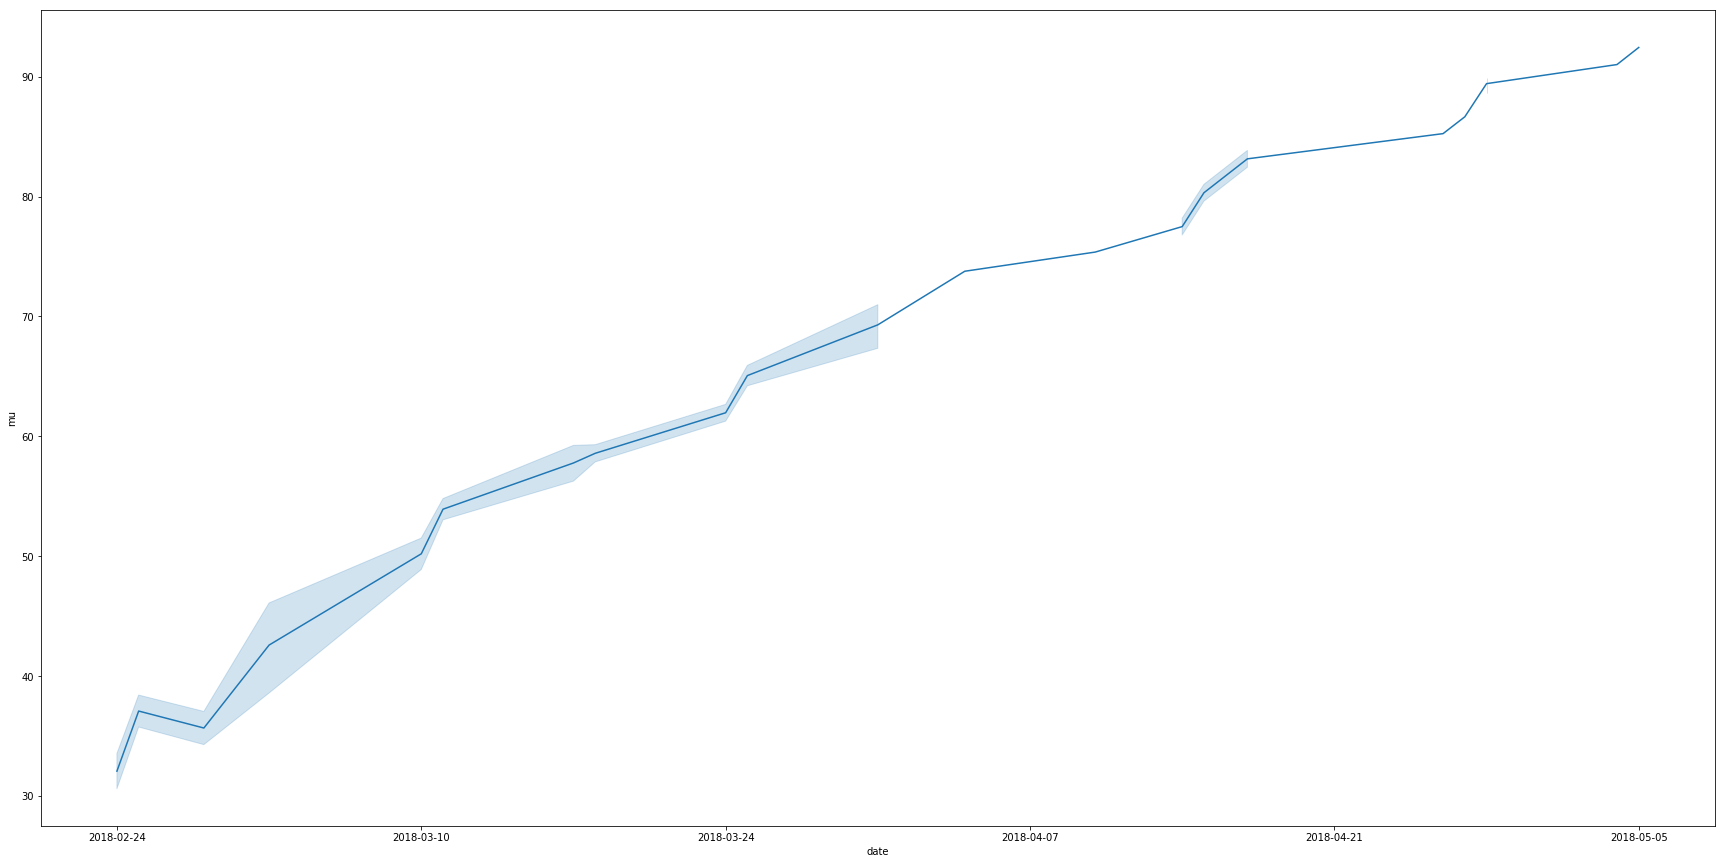

In [33]:
get_player_rating_history(d_2018['match_history'], 'Abril Bustamante')

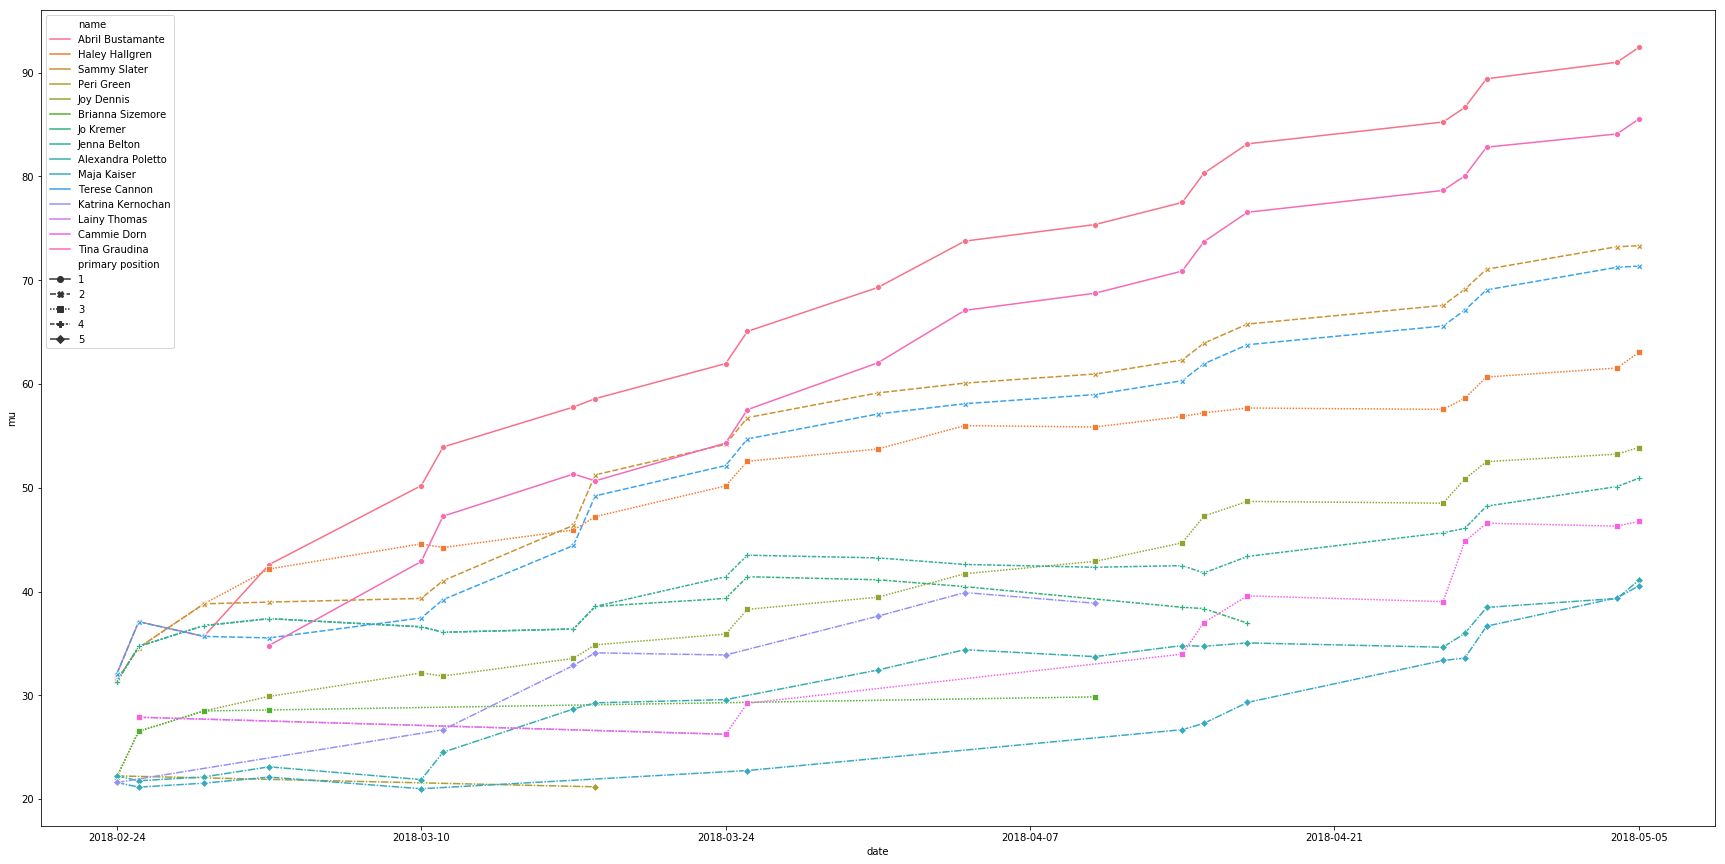

In [37]:
plot_team_players_history(d_2018['match_history'], 'USC')